<a href="https://colab.research.google.com/github/anjali88/HFT-ML/blob/master/Technical_Indicator_FFT_XGBoost_(FE)_stack_encoder_ensemble_xgb_RLPG_ForecastLSTM_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install utils

In [0]:
!pip install mxnet

     |████████████████████████████████| 25.4MB 1.7MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import sqrt
import time
import datetime
from utils import *
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from sklearn.decomposition import PCA
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving GS.xlsx to GS.xlsx


In [0]:
import io
data = pd.read_excel(io.BytesIO(uploaded['GS.xlsx']))
print(data)
# if we want to know what sort of detail is provided with this dataset, we can call .keys()
data.keys()

           Date     Open     High      Low    Close    Volume  OpenInt
0    1999-05-04   67.665   68.780   62.329   62.659  24472946        0
1    1999-05-05   62.213   62.213   58.991   61.547   8295140        0
2    1999-05-06   60.542   61.773   59.712   60.488   3185852        0
3    1999-05-07   60.488   66.671   59.429   65.998   5331091        0
4    1999-05-10   65.331   65.441   62.549   62.941   2839054        0
...         ...      ...      ...      ...      ...       ...      ...
4656 2017-11-06  243.500  244.579  241.670  243.490   1733854        0
4657 2017-11-07  243.910  244.980  238.840  239.810   2435057        0
4658 2017-11-08  239.200  242.320  237.550  241.250   2349422        0
4659 2017-11-09  239.510  242.367  237.840  240.790   2122535        0
4660 2017-11-10  241.690  243.320  240.000  240.150   1844519        0

[4661 rows x 7 columns]


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [0]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 4661 number of days in the dataset.


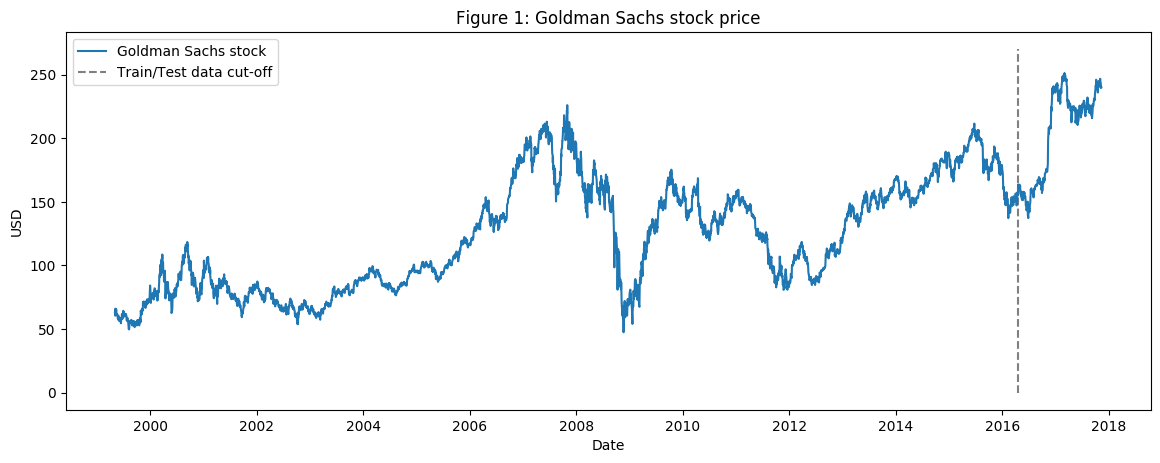

In [0]:
# Let's visualize the stock for the last 17 years. The dashed vertical line represents the separation between training and test data.
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data['Date'], data['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: Goldman Sachs stock price')
plt.legend()
plt.show()

In [0]:
num_training_days = int(data.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    data.shape[0]-num_training_days))

Number of training days: 3262. Number of test days: 1399.


#Technical Indicators
Lot of investors follow technical indicators. We will include the most popular indicators as independent features. Among them - 7 and days moving average, exponential moving average, momentum, Bollinger bands, MACD.

In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.DataFrame.ewma(dataset['Close'], span=26)
    #dataset['12ema'] = pd.DataFrame.ewma(dataset['Close'], span=12)
    #dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [0]:
data_TI = get_technical_indicators(data[['Close']])
data_TI.head()

,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,62.659,NaN,NaN,62.659000,62.659000,0.000000,NaN,NaN,NaN,62.659000,61.659
1,61.547,NaN,NaN,62.081615,62.056667,-0.024949,NaN,NaN,NaN,61.825000,60.547
2,60.488,NaN,NaN,61.509045,61.444416,-0.064629,NaN,NaN,NaN,60.899385,59.488
3,65.998,NaN,NaN,62.763961,62.881804,0.117844,NaN,NaN,NaN,64.340950,64.998
4,62.941,NaN,NaN,62.805017,62.897888,0.092871,NaN,NaN,NaN,63.403793,61.941


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Figure 2: Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

# Let's visualize the last 400 days of these indicators.

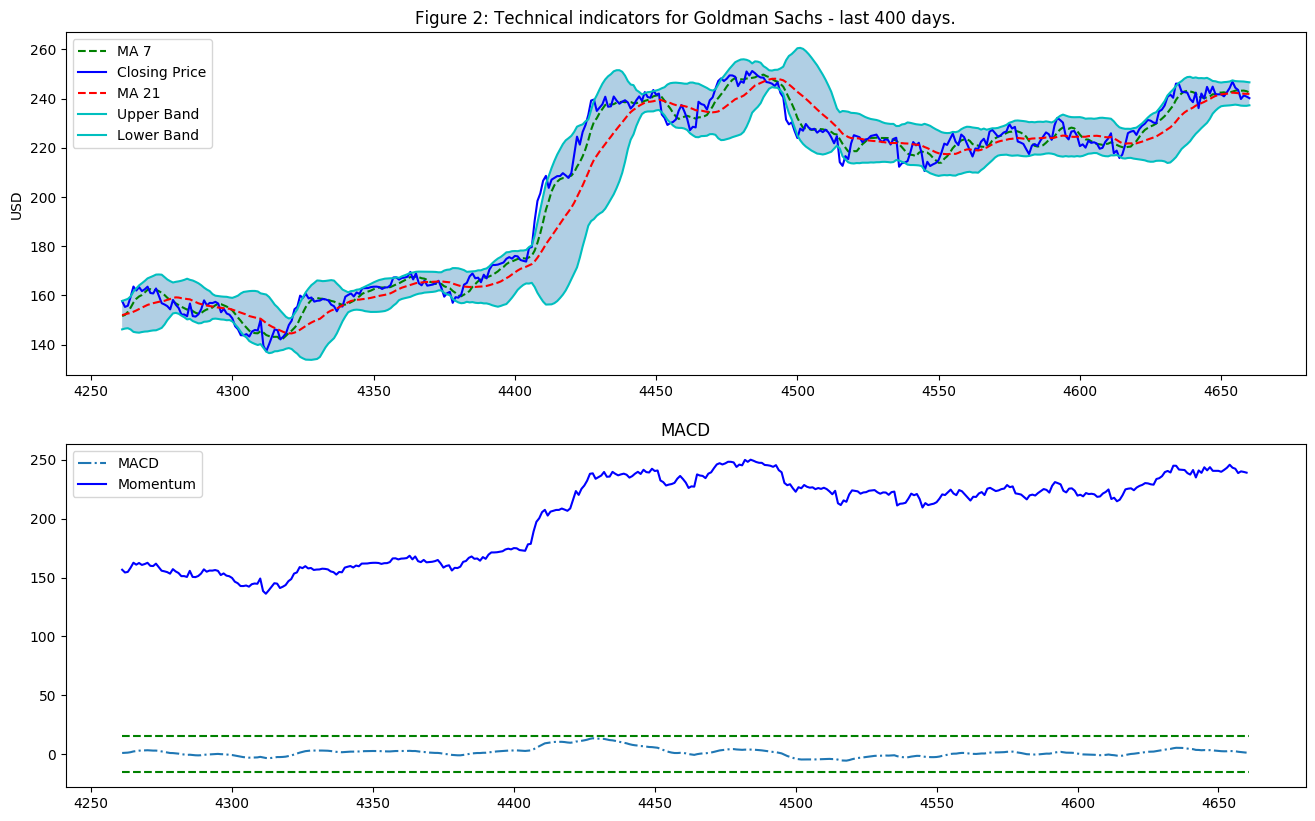

In [0]:
plot_technical_indicators(data_TI, 400)



#FFT
Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function. Mathematically speaking, the transforms look like this:

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

We will use Fourier transforms to extract global and local trends in the GS, and to also denoise it a little. 

# Fourier transforms for trend analysis 

In [0]:
data_FT = data[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

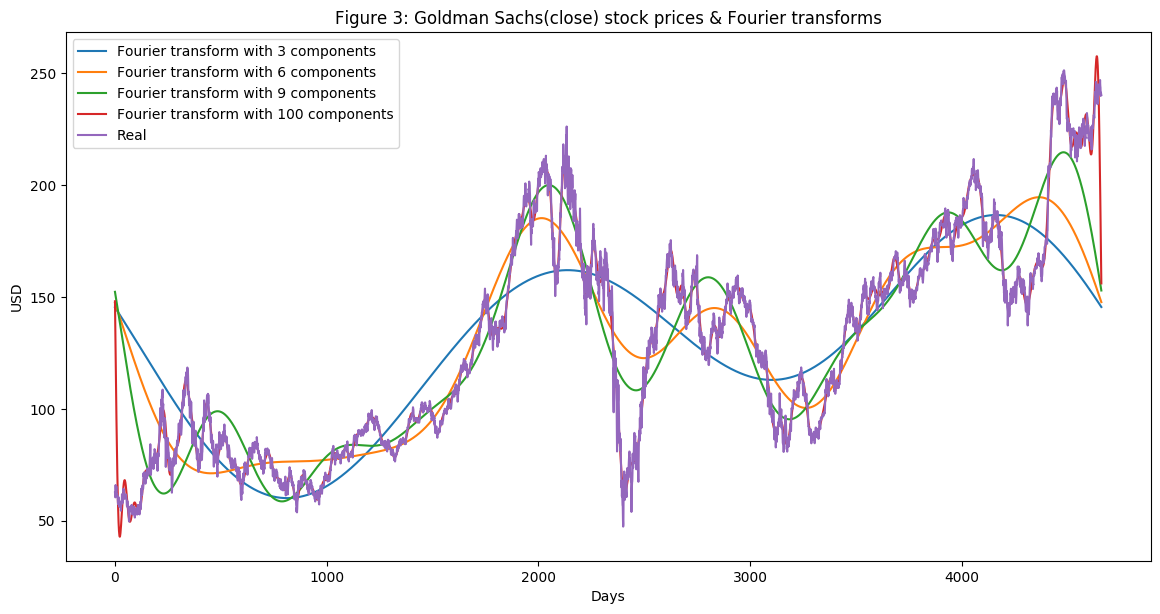

In [0]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs(close) stock prices & Fourier transforms')
plt.legend()
plt.show()

As you see in Figure above the more components from the Fourier transform we use, the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap. We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

Another technique used to denoise data is call wavelets. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.

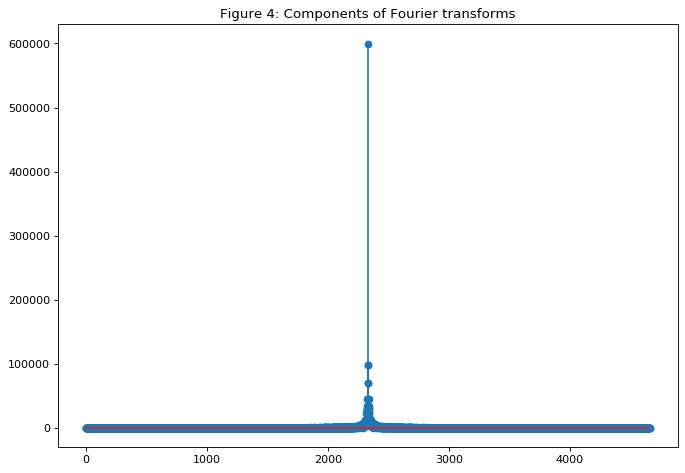

In [0]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# Feature Engineering
Technical Indicators Importance using XGBoost

In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [0]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(data_TI)

In [0]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [0]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[16:59:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
eval_result = regressor.evals_result()


In [0]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds

range(0, 150)

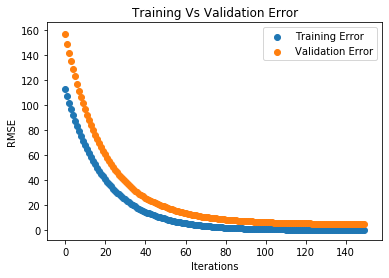

In [0]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()


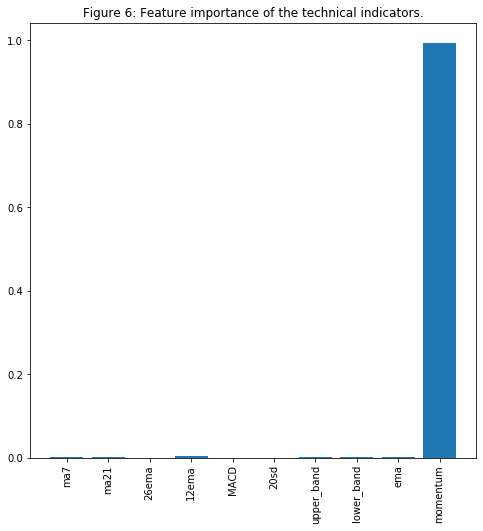

In [0]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

# Stack-encoder-ensemble-xgb

In [0]:
df = data[['Date','Open', 'High', 'Close']]
df.head()

,Date,Open,High,Close
0,1999-05-04,67.665,68.780,62.659
1,1999-05-05,62.213,62.213,61.547
2,1999-05-06,60.542,61.773,60.488
3,1999-05-07,60.488,66.671,65.998
4,1999-05-10,65.331,65.441,62.941


In [0]:
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 3].values.reshape((-1,1))).reshape((-1))

In [0]:
close_normalize.shape

(4661,)

In [0]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [0]:
import tensorflow as tf
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10 loss: 0.21341482 time: 0.012697696685791016
epoch: 20 loss: 0.2134145 time: 0.012586116790771484
epoch: 30 loss: 0.21341391 time: 0.01224064826965332
epoch: 40 loss: 0.2134129 time: 0.014496326446533203
epoch: 50 loss: 0.21341115 time: 0.01265406608581543
epoch: 60 loss: 0.21340813 time: 0.012516498565673828
epoch: 70 loss: 0.21340263 time: 0.01278543472290039
epoch: 80 loss: 0.21339196 time: 0.012580394744873047
epoch: 90 loss: 0.21336913 time: 0.013386249542236328
epoch: 100 loss: 0.2133063 time: 0.012700080871582031


(4661, 32)

In [0]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [0]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

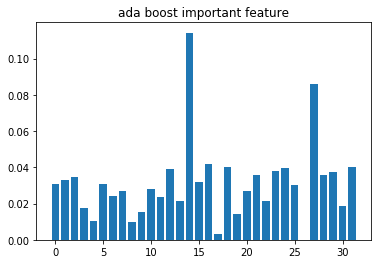

In [0]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

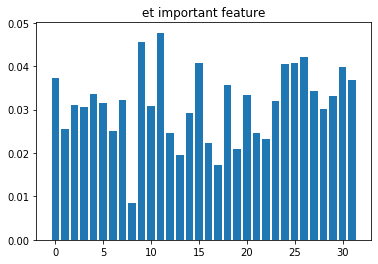

In [0]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()


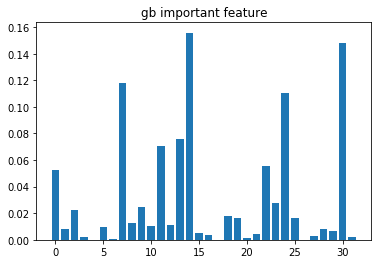

In [0]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

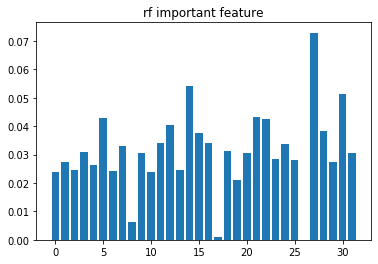

In [0]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [0]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [0]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

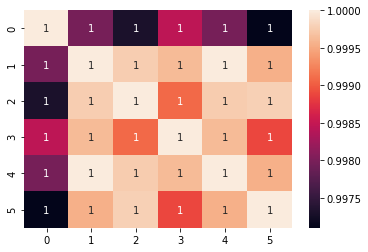

In [0]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

In [0]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [0]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

In [0]:
from datetime import timedelta
sns.set()

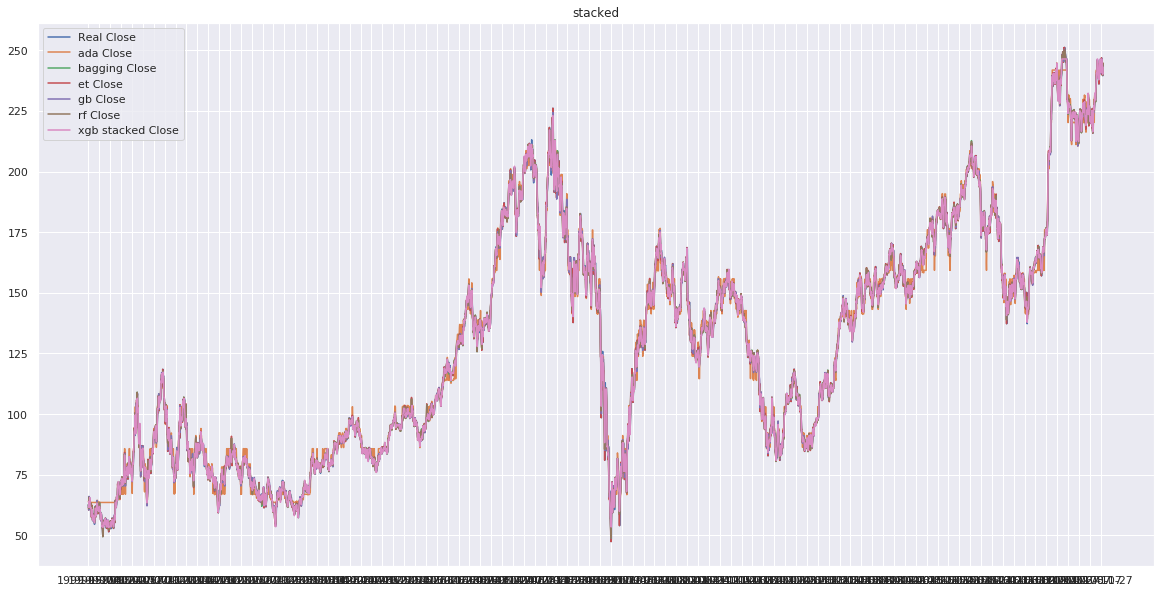

In [0]:
plt.figure(figsize = (20,10))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [0]:
ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [0]:
predict(30, history = 5)

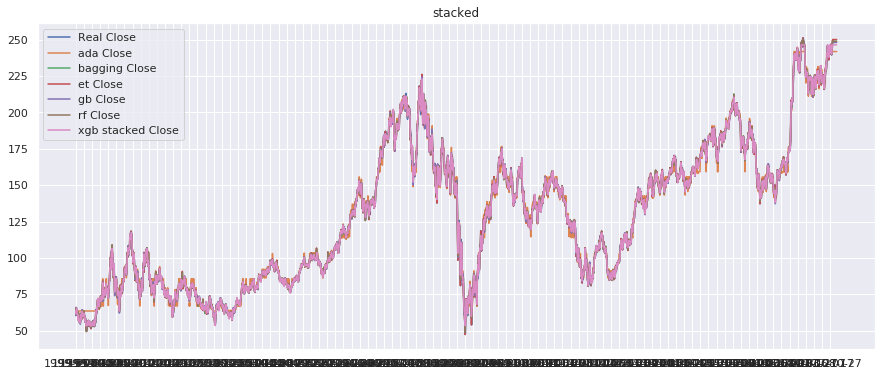

In [0]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

#RL - Policy Gradient agent
This agent only able to buy or sell 1 unit per transaction.

In [0]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: -45.800000.3, cost: -23880.023438, total money: 9954.200000
epoch: 20, total rewards: -49.333000.3, cost: -25016.597656, total money: 9950.667000
epoch: 30, total rewards: -102.859000.3, cost: -26046.818359, total money: 9897.141000
epoch: 40, total rewards: -91.829000.3, cost: -26940.818359, total money: 9908.171000
epoch: 50, total rewards: 102.404000.3, cost: -27704.980469, total money: 10102.404000
epoch: 60, total rewards: 233.490000.3, cost: -28550.693359, total money: 10233.490000
epoch: 70, total rewards: 211.521000.3, cost: -29118.195312, total money: 10211.521000
epoch: 80, total rewards: 93.087000.3, cost: -29202.013672, total money: 10093.087000
epoch: 90, total rewards: 1586.960000.3, cost: -29549.417969, total money: 11586.960000
epoch: 100, total rewards: 2624.729000.3, cost: -29646.314453, total money: 12624.729000
e

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 62.659000, total balance 9937.341000
day 1: buy 1 unit at price 61.547000, total balance 9875.794000
day 2, sell 1 unit at price 60.488000, investment -3.464786 %, total balance 9936.282000,
day 3: buy 1 unit at price 65.998000, total balance 9870.284000
day 5: buy 1 unit at price 62.888000, total balance 9807.396000
day 6, sell 1 unit at price 65.441000, investment 6.326872 %, total balance 9872.837000,
day 7, sell 1 unit at price 65.166000, investment -1.260644 %, total balance 9938.003000,
day 9: buy 1 unit at price 61.098000, total balance 9876.905000
day 11: buy 1 unit at price 61.710000, total balance 9815.195000
day 13: buy 1 unit at price 60.107000, total balance 9755.088000
day 17: buy 1 unit at price 60.323000, total balance 9694.765000
day 18, sell 1 unit at price 60.488000, investment -3.816308 %, total balance 9755.253000,
day 19: buy 1 unit at price 57.149000, total balance 9698.104000
day 20, sell 1 unit at price 56.320000, investment -7.820223

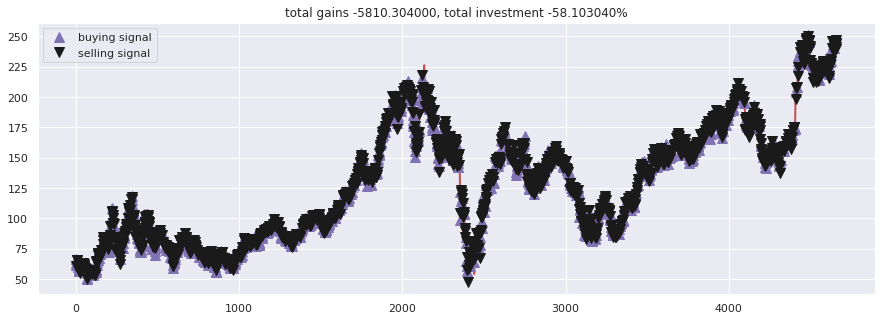

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

#Forecast - LSTM
forecast 30 days ahead! So just change test_size to forecast t + N ahead.

simulate 10 times, 10 variances of forecasted patterns by changing simulation_size.

In [0]:
df1 =  data
df1.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1,1999-05-05,62.213,62.213,58.991,61.547,8295140,0
2,1999-05-06,60.542,61.773,59.712,60.488,3185852,0
3,1999-05-07,60.488,66.671,59.429,65.998,5331091,0
4,1999-05-10,65.331,65.441,62.549,62.941,2839054,0


In [0]:
minmax = MinMaxScaler().fit(df1.iloc[:, 4:5].astype('float32')) # Close index


In [0]:
df_log = minmax.transform(df1.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.074748
1,0.069290
2,0.064093
3,0.091136
4,0.076132


In [0]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df1.shape, df_train.shape

((4661, 7), (4661, 1))

In [0]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [0]:
tf.compat.v1.random.set_random_seed(1234)

In [0]:
from tqdm import tqdm
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


train loop: 100%|██████████| 300/300 [25:00<00:00,  5.07s/it, acc=94.6, cost=0.00958]


simulation 2


train loop: 100%|██████████| 300/300 [24:40<00:00,  4.96s/it, acc=98.1, cost=0.00112]


simulation 3


train loop: 100%|██████████| 300/300 [24:17<00:00,  4.88s/it, acc=98.3, cost=0.000851]


simulation 4


train loop: 100%|██████████| 300/300 [24:30<00:00,  4.86s/it, acc=97.9, cost=0.00129]


simulation 5


train loop: 100%|██████████| 300/300 [24:31<00:00,  4.86s/it, acc=98.4, cost=0.000675]


simulation 6


train loop: 100%|██████████| 300/300 [24:33<00:00,  4.90s/it, acc=98.4, cost=0.000678]


simulation 7


train loop: 100%|██████████| 300/300 [24:35<00:00,  4.92s/it, acc=98.1, cost=0.00107]


simulation 8


train loop: 100%|██████████| 300/300 [24:32<00:00,  4.89s/it, acc=98, cost=0.00097]


simulation 9


train loop: 100%|██████████| 300/300 [24:28<00:00,  4.85s/it, acc=98.3, cost=0.000824]


simulation 10


train loop: 100%|██████████| 300/300 [24:17<00:00,  4.95s/it, acc=98, cost=0.00112]


In [0]:
date_ori = pd.to_datetime(df1.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2017-12-06', '2017-12-07', '2017-12-08', '2017-12-09', '2017-12-10']

#Sanity Check
Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,

If one of element in forecasted trend lower than min(original trend).
If one of element in forecasted trend bigger than max(original trend) * 2.
If both are true, reject that trend.


In [0]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

9

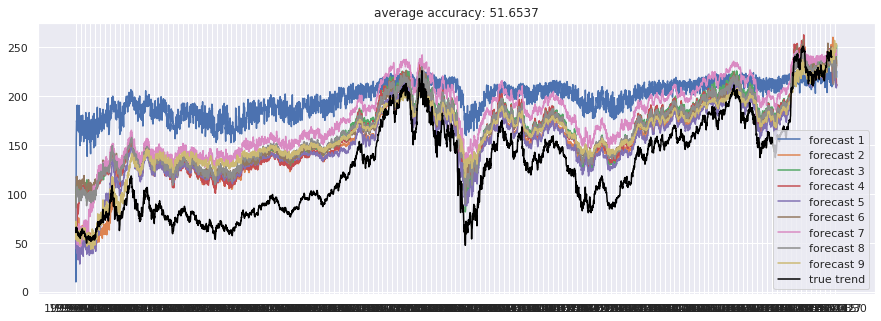

In [0]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()